<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Build-Models" data-toc-modified-id="Build-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build Models</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Model-fit-and-perforemance" data-toc-modified-id="Model-fit-and-perforemance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model fit and perforemance</a></span></li></ul></li></ul></div>

Once we have our feature vectors built, we'll try several machine learning classification models in order to find which one performs best on our data. We will try with the following models:

* Baseline Classifier
* Random Forest
* Support Vector Machine
* K Nearest Neighbors
* Multinomial Naïve Bayes
* Multinomial Logistic Regression
* Gradient Boosting

The methodology used to train each model is as follows:

1. First of all, we'll decide which hyperparameters we want to tune.
2. Secondly, we'll define the metric we'll get when measuring the performance of a model. In this case, we'll use the **accuracy**.
3. We'll perform a Randomized Search Cross Validation process in order to find the hyperparameter region in which we get higher values of accuracy. 
4. Once we find that region, we'll use a Grid Search Cross Validation process to exhaustively find the best combination of hyperparameters.
5. Once we obtain the best combination of hyperparameters, we'll obtain the accuracy on the training data and the test data, the classification report and the confusion matrix.
6. Finally, we'll calculate the accuracy of a model with default hyperparameters, to see if we have achieved better results by hyperparameter tuning.

We need to be aware of the fact that our dataset only contains 5 categories:

* Business
* Politics
* Sports
* Tech
* Entertainment

So, when we get news articles that don't belong to any of that categories (for example, weather or terrorism news articles), we will surely get a wrong prediction. For this reason we will take into account the conditional probability of belonging to every class and set a lower threshold (i.e. if the 5 conditional probabilities are lower than 65% then the prediction will be 'other'). This probability vector can be obtained in a simple way in some models, but not in other ones. For this reason we will take this into consideration when choosing the model to use.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Dataframe
path_df = '/Users/jimcody/Documents/2021Python/nlp/data/Pickles/df.pickle'
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = '/Users/jimcody/Documents/2021Python/nlp/data/Pickles/features_train.pickle'
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = '/Users/jimcody/Documents/2021Python/nlp/data/Pickles/labels_train.pickle'
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = '/Users/jimcody/Documents/2021Python/nlp/data/Pickles/features_test.pickle'
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = '/Users/jimcody/Documents/2021Python/nlp/data/Pickles/labels_test.pickle'
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [4]:
print(features_train.shape)
print(features_test.shape)

(1891, 300)
(334, 300)


# Build Models

## Random Forest

In [5]:
rf_0 = RandomForestClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(rf_0.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

* `n_estimators` = number of trees in the forest.
* `max_features` = max number of features considered for splitting a node
* `max_depth` = max number of levels in each decision tree
* `min_samples_split` = min number of data points placed in a node before the node is split
* `min_samples_leaf` = min number of data points allowed in a leaf node
* `bootstrap` = method for sampling data points (with or without replacement)

In [6]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


Cross-validation is a statistical method used to estimate the performance (or accuracy) of machine learning models. It is used to protect against overfitting in a predictive model, particularly in a case where the amount of data may be limited. In cross-validation, you make a fixed number of folds (or partitions) of the data, run the analysis on each fold, and then average the overall error estimate.

In [7]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [8]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.9434181068095491


In [9]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=8),
             param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [800]},
             scoring='accuracy', verbose=1)

In [10]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.9450666666666668


In [11]:
best_rfc = grid_search.best_estimator_

In [12]:
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_split=5, n_estimators=800, random_state=8)

## Model fit and perforemance

In [13]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_split=5, n_estimators=800, random_state=8)

In [14]:
rfc_pred = best_rfc.predict(features_test)

In [15]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
1.0


In [16]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.9281437125748503


In [17]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        81
           1       0.90      0.94      0.92        49
           2       0.97      0.86      0.91        72
           3       0.97      0.96      0.97        72
           4       0.95      0.93      0.94        60

    accuracy                           0.93       334
   macro avg       0.93      0.93      0.93       334
weighted avg       0.93      0.93      0.93       334



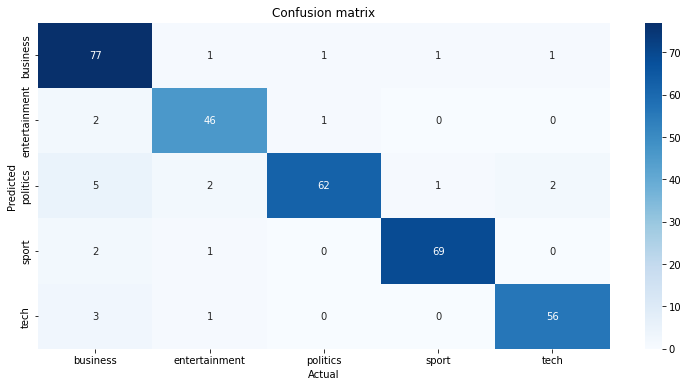

In [18]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [19]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9281437125748503

In [20]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.9281437125748503

In [21]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])

In [22]:
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,1.0,0.928144


In [23]:
with open('/Users/jimcody/Documents/2021Python/nlp/data/Pickles/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open('/Users/jimcody/Documents/2021Python/nlp/data/Pickles/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)